# Домашнее задание  № 5. Матричные разложения/Тематическое моделирование

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gensim
import pandas as pd
import numpy as np
import seaborn as sns
from pymorphy2 import MorphAnalyzer
#import pyLDAvis.gensim_models
from collections import Counter
from string import punctuation
from razdel import tokenize as razdel_tokenize
from sklearn.decomposition import TruncatedSVD, NMF, PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from matplotlib import pyplot as plt
import seaborn as sns
morph = MorphAnalyzer()
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

In [12]:
import tenzorflow as tf

ModuleNotFoundError: No module named 'tenzorflow'

### Задание № 1 (8 баллов)

Попробуйте матричные разложения с 4 классификаторами - SGDClassifier, KNeighborsClassifier,  RandomForest, ExtraTreesClassifier (про него подробнее почитайте в документации, он похож на RF). Используйте и NMF, SVD и LDA. Сравните результаты на кросс-валидации и выберите лучшее сочетание.

В итоге у вас должно получиться, как минимум 12 моделей (три разложения на каждый классификатор). Используйте 1 и те же параметры кросс-валидации. Параметры векторизации, параметры K в матричных разложениях, параметры классификаторов могут быть разными между экспериментами.

Можете взять поменьше данных, если все будет обучаться слишком долго (не ставьте параметр K слишком большим в NMF и LDA, иначе точно будет слишком долго)

In [2]:
data = pd.read_csv('data/avito_category_classification.csv')

In [3]:
data

,category_name,description
0,Автомобили,"отличное состояние,обслужиание в салоне"
1,Детская одежда и обувь,В отличном состоянии. Фирма KIKO. Очень теплый...
2,Предложение услуг,"Изготовление ограждений, перил,качелей, турник..."
3,Автомобили,Автомобиль в отличном техническом состоянии. О...
4,Бытовая техника,"Продается газовая плита ""Гефест"" (Белоруссия) ..."
...,...,...
9893,Товары для детей и игрушки,Чтобы посмотреть весь ассортимент нашего магаз...
9894,Детская одежда и обувь,"Весна,осень.74-80.вопросы можно в вайбер,двухс..."
9895,"Одежда, обувь, аксессуары","Кимоно Green Hill. Состояние отличное, рост ..."
9896,Детская одежда и обувь,Б/у кроссовки на девочку. Носили только в спор...


In [4]:
# добавим лемматизацию
def normalize(text):
    normalized_text = [word.text.strip(punctuation) for word \
                                                            in razdel_tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word and len(word) < 20 ]
    normalized_text = [morph.parse(word)[0].normal_form for word in normalized_text]
    return ' '.join(normalized_text)

In [5]:
data['description_norm'] = data['description'].apply(normalize)

In [11]:
"""pipeline_bow = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10))
])"""

"pipeline_bow = Pipeline([\n    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),\n    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10))\n])"

In [6]:
pipeline_svd_rf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10))
])

pipeline_svd_knn = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

pipeline_svd_sgd = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3))
])
pipeline_svd_etc = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', ExtraTreesClassifier(n_estimators=100, random_state=0))
])

In [7]:
pipeline_nmf_rf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=6))
])

pipeline_nmf_knn = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

pipeline_nmf_sgd = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3))
])

pipeline_nmf_etc = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', ExtraTreesClassifier(n_estimators=100, random_state=0))
])

In [8]:
pipeline_lda_rf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('lda', LatentDirichletAllocation(50)),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=6))
])

pipeline_lda_knn = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('lda', LatentDirichletAllocation(50)),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

pipeline_lda_sgd = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('lda', LatentDirichletAllocation(50)),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3))
])

pipeline_lda_etc = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('lda', LatentDirichletAllocation(50)),
    ('clf', ExtraTreesClassifier(n_estimators=100, random_state=0))
])

In [9]:
def eval_table(X, y, pipeline, N=6):
    # зафиксируем порядок классов
    labels = list(set(y))
    
    # метрики отдельных фолдов будет хранить в табличке
    fold_metrics = pd.DataFrame(index=labels)
    # дополнительно также соберем таблицу ошибок
    errors = np.zeros((len(labels), len(labels)))
    
    # создаем стратегию кросс-валидации
    # shuffle=True (перемешивание) - часто критично важно указать
    # т.к. данные могут быть упорядочены и модель на этом обучится
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        # fit-predict как и раньше, но сразу пайплайном
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        # записываем метрику и индекс фолда
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')
    
    # таблица для усредненных значений
    # тут мы берем колонки со значениями и усредняем их
    # часто также все метрики сразу суммируют и в конце просто делят на количество фолдов
    # но мы тут помимо среднего также хотим посмотреть на стандартное отклонение
    # чтобы понять как сильно варьируются оценки моделей
    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)
    
    # добавим одну колонку со средним по всем классам
    result.loc['mean'] = result.mean().round(2)
    # проценты ошибок просто усредняем
    errors /= N
    
    return result, errors

In [10]:
metrics_svd_rf, errors_svd_rf = eval_table(data['description_norm'], data['category_name'], pipeline_svd_rf)
metrics_svd_knn, errors_svd_knn = eval_table(data['description_norm'], data['category_name'], pipeline_svd_knn)
metrics_svd_sgd, errors_svd_sgd = eval_table(data['description_norm'], data['category_name'], pipeline_svd_sgd)
metrics_svd_etc, errors_svd_etc = eval_table(data['description_norm'], data['category_name'], pipeline_svd_etc)

In [11]:
metrics_svd_rf

,precision,precision_std,recall,recall_std,f1,f1_std
Бытовая техника,0.88,0.20,0.06,0.03,0.11,0.05
Телефоны,0.95,0.04,0.34,0.07,0.49,0.07
Предложение услуг,0.76,0.07,0.49,0.06,0.59,0.03
Автомобили,0.87,0.03,0.60,0.04,0.71,0.03
Мебель и интерьер,0.71,0.35,0.03,0.02,0.06,0.04
Квартиры,0.87,0.02,0.89,0.01,0.88,0.01
Товары для детей и игрушки,0.80,0.09,0.17,0.04,0.28,0.05
Ремонт и строительство,0.78,0.13,0.08,0.02,0.15,0.03
"Одежда, обувь, аксессуары",0.47,0.01,0.76,0.03,0.58,0.01
Детская одежда и обувь,0.45,0.01,0.69,0.03,0.54,0.01


In [18]:
metrics_lda_rf, errors_lda_rf = eval_table(data['description_norm'], data['category_name'], pipeline_lda_rf)
metrics_lda_knn, errors_lda_knn = eval_table(data['description_norm'], data['category_name'], pipeline_lda_knn)
metrics_lda_sgd, errors_lda_sgd = eval_table(data['description_norm'], data['category_name'], pipeline_lda_sgd)
metrics_lda_etc, errors_lda_etc = eval_table(data['description_norm'], data['category_name'], pipeline_lda_etc)

In [19]:
metrics_nmf_rf, errors_nmf_rf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_rf)
metrics_nmf_knn, errors_nmf_knn = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_knn)
metrics_nmf_sgd, errors_nmf_sgd = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_sgd)
metrics_nmf_etc, errors_nmf_etc = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_etc)

In [103]:
d = {'Metrics': metrics_lda_rf.loc['mean'].keys(), 'lda_rf': metrics_lda_rf.loc['mean'].values,
    'lda_sgd': metrics_lda_sgd.loc['mean'].values, 'lda_knn': metrics_lda_knn.loc['mean'].values,
    'lda_etc': metrics_lda_etc.loc['mean'].values, 'svd_rf': metrics_svd_rf.loc['mean'].values,
    'svd_sgd': metrics_svd_sgd.loc['mean'].values, 'svd_knn': metrics_svd_knn.loc['mean'].values,
    'svd_etc': metrics_svd_etc.loc['mean'].values,'nmf_rf': metrics_nmf_rf.loc['mean'].values,
    'nmf_sgd': metrics_nmf_sgd.loc['mean'].values, 'nmf_knn': metrics_nmf_knn.loc['mean'].values,
    'nmf_etc': metrics_nmf_etc.loc['mean'].values}
df_metrics = pd.DataFrame(data=d)
df_metrics

,Metrics,lda_rf,lda_sgd,lda_knn,lda_etc,svd_rf,svd_sgd,svd_knn,svd_etc,nmf_rf,nmf_sgd,nmf_knn,nmf_etc
0,precision,0.58,0.58,0.58,0.62,0.76,0.76,0.51,0.68,0.76,0.64,0.48,0.75
1,precision_std,0.12,0.11,0.05,0.05,0.09,0.05,0.04,0.09,0.10,0.19,0.04,0.04
2,recall,0.43,0.56,0.55,0.58,0.41,0.73,0.44,0.37,0.46,0.45,0.48,0.70
3,recall_std,0.08,0.07,0.04,0.04,0.03,0.05,0.04,0.03,0.05,0.14,0.04,0.04
4,f1,0.44,0.55,0.55,0.59,0.44,0.74,0.46,0.41,0.49,0.44,0.47,0.71
5,f1_std,0.06,0.06,0.04,0.04,0.04,0.03,0.04,0.04,0.05,0.11,0.04,0.03


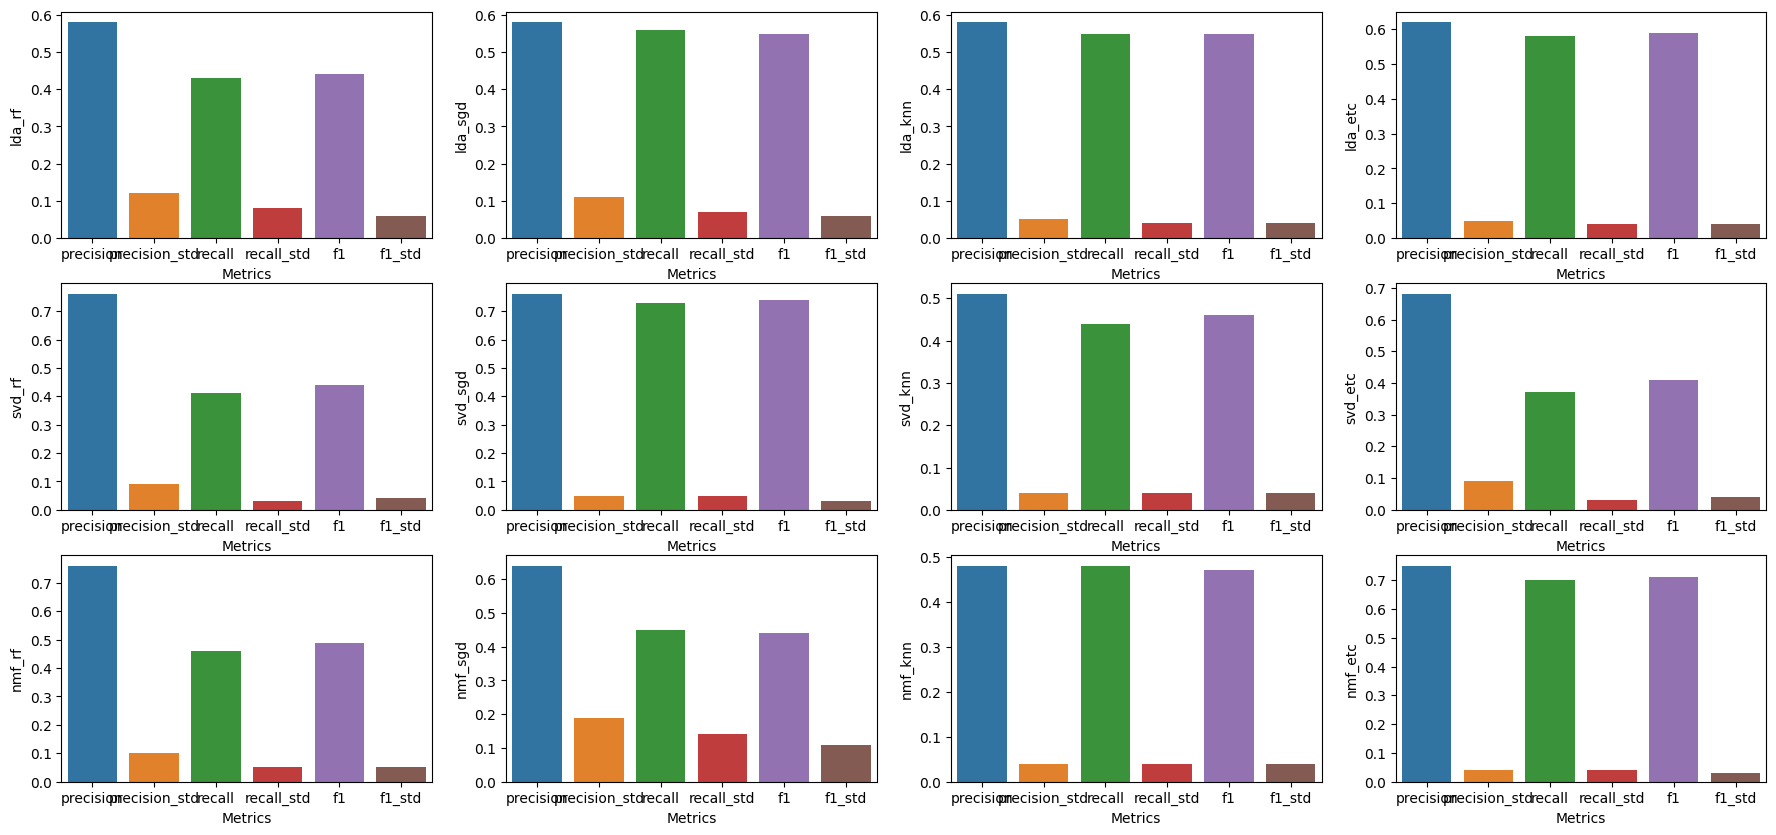

In [114]:
fig, axes = plt.subplots(3, 4, figsize=(22, 10))

ax = sns.barplot(x='Metrics', y='lda_rf',
            data=df_metrics, orient='v', ax=axes[0, 0])

ax = sns.barplot(x='Metrics', y='lda_sgd',
            data=df_metrics, orient='v', ax=axes[0, 1])

ax = sns.barplot(x='Metrics', y='lda_knn',
            data=df_metrics, orient='v', ax=axes[0, 2])

ax = sns.barplot(x='Metrics', y='lda_etc',
            data=df_metrics, orient='v', ax=axes[0, 3])


ax = sns.barplot(x='Metrics', y='svd_rf',
            data=df_metrics, orient='v', ax=axes[1, 0])

ax = sns.barplot(x='Metrics', y='svd_sgd',
            data=df_metrics, orient='v', ax=axes[1, 1])

ax = sns.barplot(x='Metrics', y='svd_knn',
            data=df_metrics, orient='v', ax=axes[1, 2])

ax = sns.barplot(x='Metrics', y='svd_etc',
            data=df_metrics, orient='v', ax=axes[1, 3])



ax = sns.barplot(x='Metrics', y='nmf_rf',
            data=df_metrics, orient='v', ax=axes[2, 0])

ax = sns.barplot(x='Metrics', y='nmf_sgd',
            data=df_metrics, orient='v', ax=axes[2, 1])

ax = sns.barplot(x='Metrics', y='nmf_knn',
            data=df_metrics, orient='v', ax=axes[2, 2])

ax = sns.barplot(x='Metrics', y='nmf_etc',
            data=df_metrics, orient='v', ax=axes[2, 3])


### Задание № 2 (2 балла)

С помощью gensim постройте 5 тематических моделей с разными параметрами. Как минимум попробуйте: разное количество тем, alpha и eta параметры (в альфа попробуйте "asymmetric" и "auto" помимо 'symmetric' по дефолту, в eta просто попробуйте разные значения), а также разные параметры фильтрации словаря. 

Оцените каждую из моделей с помощью метрик (перплексии и когерентности), а также визуально, просмотрев получаемые темы. Найдите самую хорошую тему для каждой из моделей.

In [13]:
texts = open('data/wiki_data.txt').read().splitlines()[:5000]
texts = ([normalize(text) for text in texts])

In [14]:
vectorizer = TfidfVectorizer(max_features=2000, min_df=10, max_df=0.4)
X = vectorizer.fit_transform(texts)

In [ ]:
dictinary = gensim.corpora.Dictionary((text.split() for text in texts))

In [67]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [68]:
corpus = [dictinary.doc2bow(text.split()) for text in texts]

In [83]:
lda = gensim.models.LdaModel(corpus, 200, alpha='symmetric', id2word=dictinary, passes=5)

In [84]:
lda.print_topics()

[(171,
  '0.221*"список" + 0.132*"значение" + 0.069*"таблица" + 0.050*"запись" + 0.042*"100" + 0.034*"пример" + 0.028*"севастополь" + 0.025*"условие" + 0.022*"раздел" + 0.022*"колонка"'),
 (93,
  '0.051*"северный" + 0.050*"монголия" + 0.037*"встречаться" + 0.030*"европа" + 0.028*"семейство" + 0.026*"распространить" + 0.022*"личинка" + 0.019*"америка" + 0.019*"яйцо" + 0.018*"растение"'),
 (166,
  '0.106*"полигон" + 0.082*"испытание" + 0.071*"б" + 0.059*"ядерный" + 0.044*"арсенал" + 0.031*"далее" + 0.029*"бомба" + 0.028*"создание" + 0.028*"взрыв" + 0.020*"руководство"'),
 (49,
  '0.181*"убийство" + 0.082*"убитый" + 0.073*"убийца" + 0.072*"торговый" + 0.072*"фамилия" + 0.046*"торговля" + 0.037*"носитель" + 0.028*"статуя" + 0.022*"совершить" + 0.022*"преступный"'),
 (85,
  '0.019*"чтобы" + 0.010*"порода" + 0.009*"остаться" + 0.009*"помощь" + 0.008*"собака" + 0.008*"должный" + 0.007*"вскоре" + 0.007*"друг" + 0.006*"найти" + 0.006*"убить"'),
 (89,
  '0.179*"завод" + 0.064*"производство" + 0.

In [85]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

1180.3821646872186

In [86]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

In [87]:
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

In [88]:
coherence_model_lda.get_coherence()

0.49558064814057984

In [77]:
lda = gensim.models.LdaModel(corpus, 200, alpha='asymmetric', id2word=dictinary, passes=5)
lda.print_topics()

[(199,
  '0.054*"воздух" + 0.036*"система" + 0.027*"сигнал" + 0.023*"камера" + 0.020*"сибирский" + 0.020*"антенна" + 0.019*"поток" + 0.018*"патрик" + 0.017*"ветеринарный" + 0.017*"промежуточный"'),
 (197,
  '0.039*"премьер-министр" + 0.038*"магнитный" + 0.031*"переходный" + 0.026*"энергия" + 0.025*"ток" + 0.024*"вероятность" + 0.021*"независимость" + 0.016*"форт" + 0.016*"электрический" + 0.016*"переход"'),
 (198,
  '0.068*"красный" + 0.051*"чёрный" + 0.045*"цвета" + 0.042*"белый" + 0.038*"крыло" + 0.036*"сторона" + 0.035*"цвет" + 0.029*"нижний" + 0.028*"глаз" + 0.027*"пятно"'),
 (192,
  '0.138*"польша" + 0.099*"германия" + 0.085*"польский" + 0.049*"печать" + 0.038*"колония" + 0.030*"коми" + 0.029*"австрия" + 0.026*"франция" + 0.024*"водяной" + 0.024*"немецкий"'),
 (190,
  '0.362*"посёлок" + 0.052*"житель" + 0.046*"поселковый" + 0.038*"километр" + 0.033*"городской" + 0.025*"пгт" + 0.018*"грунтовый" + 0.015*"хозяйство" + 0.015*"статус" + 0.015*"вознесенский"'),
 (195,
  '0.049*"просвеще

In [78]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

1185.2655077346408

In [79]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

coherence_model_lda.get_coherence()

0.5012267764863864

In [15]:
dictinary = gensim.corpora.Dictionary((text.split() for text in texts))
dictinary.filter_extremes(no_above=0.2, no_below=50)
dictinary.compactify()
corpus = [dictinary.doc2bow(text.split()) for text in texts]

In [16]:
lda = gensim.models.LdaModel(corpus, 100, alpha='auto', eta='auto', id2word=dictinary, passes=10)
lda.print_topics()

[(31,
  '0.741*"привлечь" + 0.000*"список" + 0.000*"настоящий" + 0.000*"количество" + 0.000*"канада" + 0.000*"население" + 0.000*"крупный" + 0.000*"сложность" + 0.000*"момент" + 0.000*"ограничение"'),
 (79,
  '0.851*"михайло" + 0.014*"1-й" + 0.000*"мелкий" + 0.000*"ф" + 0.000*"ранний" + 0.000*"рассказ" + 0.000*"впервые" + 0.000*"школа" + 0.000*"род" + 0.000*"дом"'),
 (60,
  '0.555*"романовский" + 0.323*"малый" + 0.011*"1920" + 0.004*"1939" + 0.004*"действующий" + 0.002*"1921" + 0.000*"июль" + 0.000*"житомирский" + 0.000*"население" + 0.000*"1900"'),
 (18,
  '0.314*"помещение" + 0.231*"1908" + 0.190*"греция" + 0.134*"жилой" + 0.008*"показывать" + 0.008*"дополнительный" + 0.008*"часть" + 0.005*"официальный" + 0.004*"относиться" + 0.003*"постоянный"'),
 (53,
  '0.198*"1900" + 0.132*"харьковский" + 0.128*"1914" + 0.095*"1934" + 0.081*"карл" + 0.063*"1915" + 0.053*"ф" + 0.036*"январь" + 0.028*"высокий" + 0.017*"издать"'),
 (95,
  '0.137*"установка" + 0.134*"машина" + 0.103*"орудие" + 0.092*

In [17]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

200.09979205941164

In [18]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

coherence_model_lda.get_coherence()

0.5891937571775725

In [92]:
lda = gensim.models.LdaModel(corpus, 400, alpha='asymmetric', id2word=dictinary, passes=10)
lda.print_topics()

[(395,
  '0.098*"пол" + 0.077*"петров" + 0.066*"двигаться" + 0.055*"арсенал" + 0.054*"быстрый" + 0.052*"защитник" + 0.051*"вилла" + 0.039*"интересный" + 0.037*"депрессия" + 0.033*"горячее"'),
 (398,
  '0.040*"наступление" + 0.038*"овладеть" + 0.033*"наш" + 0.032*"километр" + 0.025*"занять" + 0.020*"река" + 0.019*"направление" + 0.019*"украинский" + 0.017*"бой" + 0.016*"оборона"'),
 (386,
  '0.080*"западный" + 0.056*"бухта" + 0.053*"me" + 0.049*"мыс" + 0.043*"швеция" + 0.041*"1940" + 0.036*"архипелаг" + 0.034*"110" + 0.031*"карта" + 0.030*"41"'),
 (393,
  '0.171*"компания" + 0.024*"частное" + 0.023*"крупный" + 0.022*"сеть" + 0.018*"бизнес" + 0.018*"реализовать" + 0.017*"запустить" + 0.016*"сотрудник" + 0.016*"специализировать" + 0.014*"рынок"'),
 (384,
  '0.352*"1954" + 0.122*"1910" + 0.090*"бакалавр" + 0.068*"иркутский" + 0.040*"никола́" + 0.037*"поступление" + 0.036*"освещать" + 0.033*"иллинойс" + 0.033*"стипендия" + 0.033*"рецензия"'),
 (396,
  '0.217*"смит" + 0.099*"появиться" + 0.0

In [93]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

1028.0496404113687

In [94]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

coherence_model_lda.get_coherence()

0.5071833375538879

In [19]:
dictinary = gensim.corpora.Dictionary((text.split() for text in texts))
dictinary.filter_extremes(no_above=0.5, no_below=10)
dictinary.compactify()
corpus = [dictinary.doc2bow(text.split()) for text in texts]

In [20]:
lda = gensim.models.LdaModel(corpus, 800, alpha='asymmetric', id2word=dictinary, passes=3)
lda.print_topics()

[(796,
  '0.129*"армянский" + 0.066*"турция" + 0.037*"«" + 0.035*"»" + 0.029*"юбилей" + 0.027*"стратегия" + 0.025*"стамбул" + 0.025*"турецкий" + 0.021*"признание" + 0.019*"тифлис"'),
 (786,
  '0.125*"андрей" + 0.112*"1998" + 0.062*"илья" + 0.053*"дворянский" + 0.050*"сын" + 0.047*"афанасий" + 0.037*"ключ" + 0.026*"вотчина" + 0.024*"1999" + 0.021*"жаловаться"'),
 (784,
  '0.072*"лицевой" + 0.062*"сторона" + 0.051*"оборотный" + 0.045*"поместить" + 0.031*"указ" + 0.027*"новочеркасск" + 0.026*"способ" + 0.023*"сообщение" + 0.023*"региональный" + 0.022*"надпись"'),
 (779,
  '0.088*"длина" + 0.057*"мм" + 0.053*"или" + 0.050*"до" + 0.042*"сантиметр" + 0.036*"род" + 0.035*"вид" + 0.031*"ширина" + 0.023*"семейство" + 0.022*"метр"'),
 (795,
  '0.912*"де" + 0.010*"он" + 0.007*"старший" + 0.005*"который" + 0.004*"быть" + 0.004*"«" + 0.004*"»" + 0.001*"свой" + 0.001*"что" + 0.001*"один"'),
 (765,
  '0.092*"»" + 0.092*"«" + 0.084*"сезон" + 0.054*"клуб" + 0.045*"матч" + 0.043*"футбол" + 0.042*"дивизи

In [21]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

6894.6761616442645

In [22]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

coherence_model_lda.get_coherence()

0.4604289123869414